## NYPD Civilian Complaints EDA:
**Author**: Ryan Hung

**Started**: 7/26/2022

**Completed**: TBD

**Data introduction**: After New York state repealed the statute that kept police disciplinary records secret, known as 50-a, ProPublica filed a records request with New York City’s Civilian Complaint Review Board, which investigates complaints by the public about NYPD officers. The board provided us with records about closed cases for every police officer still on the force as of late June 2020 who had at least one substantiated allegation against them. The records span decades, from September 1985 to January 2020.

**Data source**: https://www.propublica.org/datastore/dataset/civilian-complaints-against-new-york-city-police-officers

**Analysis Objective**: Clean and wrangle dataset so that insights related to race can be extracted; pave the way for a machine learning model deployment to predict case outcome.

## Notebook breakdown:
1. [Loading in data](#loading-in-our-data)
2. [Data cleaning](#data-cleaning)
3. [EDA](#eda)
4. [Assessment of data missingness](#assessment-of-data-missingness)

### Loading in our data:

Before we begin, let's load in our libraries, options, and data.

In [506]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import missingno as msno
from forest.benchmarking import distance_measures
from scipy.stats import ks_2samp
sns.set_theme(style = 'darkgrid', palette='Blues_d') # Switch seaborn plotting to my favorite palette :D
pd.set_option('display.max_columns', None) # Stretches dataframe output to display every columnn

In [104]:
complaints_path = 'data/allegations_202007271729.csv'
layout_path = 'data/CCRB Data Layout Table.xlsx'
excelList = pd.ExcelFile(layout_path).sheet_names # Excel file is separated into multiple sheets
print(f"Sheets: {excelList}")

Sheets: ['Layout', 'Rank Abbrevs', 'Command Abbrevs', 'FADO', 'Dispositions']


In [105]:
layout = pd.read_excel(layout_path)
police_abbrev = pd.read_excel(layout_path, sheet_name=excelList[1]) # Details the full rank behind police abbreviations
dispositions = pd.read_excel(layout_path, sheet_name=excelList[4]) # Describes the meaning behind final verdict
complaints = pd.read_csv(complaints_path) # Dataframe of complaints
complaints.head()

,unique_mos_id,first_name,last_name,command_now,shield_no,complaint_id,month_received,year_received,month_closed,year_closed,command_at_incident,rank_abbrev_incident,rank_abbrev_now,rank_now,rank_incident,mos_ethnicity,mos_gender,mos_age_incident,complainant_ethnicity,complainant_gender,complainant_age_incident,fado_type,allegation,precinct,contact_reason,outcome_description,board_disposition
0,10004,Jonathan,Ruiz,078 PCT,8409,42835,7,2019,5,2020,078 PCT,POM,POM,Police Officer,Police Officer,Hispanic,M,32,Black,Female,38.0,Abuse of Authority,Failure to provide RTKA card,78.0,Report-domestic dispute,No arrest made or summons issued,Substantiated (Command Lvl Instructions)
1,10007,John,Sears,078 PCT,5952,24601,11,2011,8,2012,PBBS,POM,POM,Police Officer,Police Officer,White,M,24,Black,Male,26.0,Discourtesy,Action,67.0,Moving violation,Moving violation summons issued,Substantiated (Charges)
2,10007,John,Sears,078 PCT,5952,24601,11,2011,8,2012,PBBS,POM,POM,Police Officer,Police Officer,White,M,24,Black,Male,26.0,Offensive Language,Race,67.0,Moving violation,Moving violation summons issued,Substantiated (Charges)
3,10007,John,Sears,078 PCT,5952,26146,7,2012,9,2013,PBBS,POM,POM,Police Officer,Police Officer,White,M,25,Black,Male,45.0,Abuse of Authority,Question,67.0,PD suspected C/V of violation/crime - street,No arrest made or summons issued,Substantiated (Charges)
4,10009,Noemi,Sierra,078 PCT,24058,40253,8,2018,2,2019,078 PCT,POF,POF,Police Officer,Police Officer,Hispanic,F,39,NaN,NaN,16.0,Force,Physical force,67.0,Report-dispute,Arrest - other violation/crime,Substantiated (Command Discipline A)


The dataset comes with a handy dictionary of column names and their descriptions.

In [106]:
layout.drop(columns = "glossary") 

,field name,description
0,unique_mos_id,"unique ID of the officer (""member of service"")"
1,first_name,Officer's first name
2,last_name,Officer's last name
3,command_now,Officer's command assignment as of July 2020
4,complaint_id,Unique ID of the complaint
5,month_received,Month the complaint was received by CCRB
6,year_received,Year the complaint was received by CCRB
7,month_closed,Month the complaint investigation was closed b...
8,year_closed,Year the complaint investigation was closed by...
9,command_at_incident,Officer's command assignment at the time of th...


### Data cleaning:

In [107]:
complaints.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33358 entries, 0 to 33357
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   unique_mos_id             33358 non-null  int64  
 1   first_name                33358 non-null  object 
 2   last_name                 33358 non-null  object 
 3   command_now               33358 non-null  object 
 4   shield_no                 33358 non-null  int64  
 5   complaint_id              33358 non-null  int64  
 6   month_received            33358 non-null  int64  
 7   year_received             33358 non-null  int64  
 8   month_closed              33358 non-null  int64  
 9   year_closed               33358 non-null  int64  
 10  command_at_incident       31814 non-null  object 
 11  rank_abbrev_incident      33358 non-null  object 
 12  rank_abbrev_now           33358 non-null  object 
 13  rank_now                  33358 non-null  object 
 14  rank_i

It seems that the date fields `month_received`, `year_received`, `month_closed`, and `year_closed` can be converted into datetime objects.

In [108]:
complaint_times = complaints[['month_received', 'year_received', 'month_closed', 'year_closed']]
complaint_times.head()

,month_received,year_received,month_closed,year_closed
0,7,2019,5,2020
1,11,2011,8,2012
2,11,2011,8,2012
3,7,2012,9,2013
4,8,2018,2,2019


In [109]:
time_labels = [('month_received', 'year_received'), ('month_closed', 'year_closed')]
times = []

# Creates a list of datetime columns
for label in time_labels:
    times += [pd.to_datetime(complaint_times[label[0]].astype(str) + complaint_times[label[1]].astype(str), format = "%m%Y")]

complaints = complaints.assign(date_received = times[0]).assign(date_closed = times[1])
complaints[['date_received', 'date_closed']].head()

,date_received,date_closed
0,2019-07-01,2020-05-01
1,2011-11-01,2012-08-01
2,2011-11-01,2012-08-01
3,2012-07-01,2013-09-01
4,2018-08-01,2019-02-01


Let's engineer a new feature called `days_taken` which represents the duration, in days, a case took to be closed.

In [110]:
complaints['days_taken'] = (complaints['date_closed'] - complaints['date_received']) # Compute timedelta
complaints[['date_received', 'date_closed', 'days_taken']].head()

,date_received,date_closed,days_taken
0,2019-07-01,2020-05-01,305 days
1,2011-11-01,2012-08-01,274 days
2,2011-11-01,2012-08-01,274 days
3,2012-07-01,2013-09-01,427 days
4,2018-08-01,2019-02-01,184 days


In [111]:
complaints['days_taken'].describe()

count                          33358
mean     296 days 06:26:57.507044788
std      152 days 16:52:42.935615560
min                  0 days 00:00:00
25%                183 days 00:00:00
50%                303 days 00:00:00
75%                396 days 00:00:00
max               3348 days 00:00:00
Name: days_taken, dtype: object

One of the cases took 3348 days, which more than 9 years, to resolve!

In [112]:
complaints[complaints['days_taken'].dt.days == 3348] # It took 9 years just for the case to be unsubstantiated?

,unique_mos_id,first_name,last_name,command_now,shield_no,complaint_id,month_received,year_received,month_closed,year_closed,command_at_incident,rank_abbrev_incident,rank_abbrev_now,rank_now,rank_incident,mos_ethnicity,mos_gender,mos_age_incident,complainant_ethnicity,complainant_gender,complainant_age_incident,fado_type,allegation,precinct,contact_reason,outcome_description,board_disposition,date_received,date_closed,days_taken
23085,31771,Gerard,Delprete,RTCC,1973,16571,9,2008,11,2017,NARCBSI,DT3,DT3,Detective,Detective,White,M,31,Black,Male,28.0,Force,Physical force,120.0,Report-possession/sale of narcotics,Arrest - resisting arrest,Unsubstantiated,2008-09-01,2017-11-01,3348 days


Let's inspect all quantative columns.

In [113]:
complaints.describe()

,unique_mos_id,shield_no,complaint_id,month_received,year_received,month_closed,year_closed,mos_age_incident,complainant_age_incident,precinct,days_taken
count,33358.000000,33358.000000,33358.000000,33358.000000,33358.000000,33358.000000,33358.000000,33358.000000,28546.000000,33334.000000,33358
mean,18169.912495,6451.608819,23905.058217,6.323551,2010.726782,6.470772,2011.525661,32.346873,32.484201,64.365213,296 days 06:26:57.507044788
std,9566.316896,7945.641596,11954.434138,3.362951,6.034725,3.343372,6.085907,6.040944,28.408963,31.451592,152 days 16:52:42.935615560
min,2.000000,0.000000,517.000000,1.000000,1985.000000,1.000000,1985.000000,20.000000,-4301.000000,0.000000,0 days 00:00:00
25%,9671.000000,1089.000000,13684.750000,3.000000,2007.000000,4.000000,2008.000000,28.000000,23.000000,43.000000,183 days 00:00:00
50%,19215.000000,3691.000000,25132.000000,6.000000,2012.000000,6.000000,2013.000000,31.000000,30.000000,67.000000,303 days 00:00:00
75%,25412.000000,7155.000000,34252.000000,9.000000,2016.000000,9.000000,2016.000000,36.000000,41.000000,81.000000,396 days 00:00:00
max,36374.000000,31977.000000,43703.000000,12.000000,2020.000000,12.000000,2020.000000,60.000000,101.000000,1000.000000,3348 days 00:00:00


The column `complainant_age_incident` has a value of -4301, which is obviously incorrect.

In [114]:
complaints['complainant_age_incident'] = complaints['complainant_age_incident'].apply(lambda age: np.nan if age <= 0 else age) # Replace negative ages with np.nan
complaints['complainant_age_incident'].describe()

count    28538.000000
mean        32.644194
std         12.204035
min          1.000000
25%         23.000000
50%         30.000000
75%         41.000000
max        101.000000
Name: complainant_age_incident, dtype: float64

Let's inspect all qualitative columns by detailing a course of action for each qualitative column.

In [115]:
pd.concat([complaints.select_dtypes(object), complaints['precinct']], axis = 1).nunique()

first_name               1217
last_name                2835
command_now               415
command_at_incident       361
rank_abbrev_incident       18
rank_abbrev_now            20
rank_now                    8
rank_incident               8
mos_ethnicity               5
mos_gender                  2
complainant_ethnicity       8
complainant_gender          6
fado_type                   4
allegation                115
contact_reason             53
outcome_description        23
board_disposition          11
precinct                   79
dtype: int64

- `first_name`, `last_name`, `command_now`, `contact_reason`, `allegation`, and `command_at_incident` all contain dozens if not thousands of unique values that, for simplicity's sake, will be left alone
- `rank_abbrev_incident` and `rank_abbrev_now` have more unique values than `rank_now` and `rank_incident` so converting the abbreviated columns would yield more specific data
- `mos_ethnicity`, `mos_gender`, `complainant_ethnicity`, `complainant_gender`, `fado_type`, `board_disposition`, `precinct`, and `outcome_description` can be manually checked for inconsistencies and cleaned accordingly due to their limited diversity

Certain rows have differing abbreviated ranks but same full ranks.

In [116]:
find_rank_inconsistencies = lambda: complaints[(complaints['rank_abbrev_incident'] != complaints['rank_abbrev_now']) & (complaints['rank_incident'] == complaints['rank_now'])][['rank_abbrev_incident', 'rank_abbrev_now', 'rank_incident', 'rank_now']].head(10)
find_rank_inconsistencies() # Function displaying rows with different abbreviations but same full rank

,rank_abbrev_incident,rank_abbrev_now,rank_incident,rank_now
340,PO,POM,Police Officer,Police Officer
453,DT3,DT2,Detective,Detective
466,SGT,SDS,Sergeant,Sergeant
467,SGT,SDS,Sergeant,Sergeant
468,SGT,SDS,Sergeant,Sergeant
469,SGT,SDS,Sergeant,Sergeant
470,SGT,SDS,Sergeant,Sergeant
471,SGT,SDS,Sergeant,Sergeant
472,SGT,SDS,Sergeant,Sergeant
473,SGT,SDS,Sergeant,Sergeant


To ensure that full ranks stay consistent with their abbreviated ranks, we can convert abbreviated ranks because they are more specific. We can achieve this by joining the `police_abbrev` dataframe with our original dataset.

In [117]:
police_abbrev.head()

,Abbreviation,Rank
0,POM,Police Officer
1,POF,Police Officer
2,PO,Police Officer
3,PSA,Police Officer Special Assignment
4,SGT,Sergeant


In [118]:
def convert_abbrev(police_abbrev, complaints):
    # Merges twice, one for incident rank and one for current rank
    # Performs left join to keep all complaints
    merged = complaints.merge(police_abbrev, how='left', left_on=['rank_abbrev_incident'], right_on =['Abbreviation']).merge(police_abbrev, how = 'left', left_on=['rank_abbrev_now'], right_on=['Abbreviation'], suffixes=("_incident", "_now")).drop(columns = ['rank_now', 'rank_incident', 'Abbreviation_incident', 'Abbreviation_now']).rename(columns = {'Rank_now': 'rank_now', 'Rank_incident': 'rank_incident'})
    return merged

complaints = convert_abbrev(police_abbrev, complaints)

Let's check for values that were unable to be converted.

In [119]:
merged = complaints[['rank_abbrev_incident', 'rank_abbrev_now', 'rank_incident', 'rank_now']] # Finds unconverted abbreviations
print(f"{list(merged[(merged['rank_incident'].isna())]['rank_abbrev_incident'].unique())} does not exist within the police abbreviation dictionary for rank_abbrev_incident")
print(f"{list(merged[(merged['rank_now'].isna())]['rank_abbrev_now'].unique())} does not exist within the police abbreviation dictionary for rank_abbrev_now")

['DET'] does not exist within the police abbreviation dictionary for rank_abbrev_incident
['CCC'] does not exist within the police abbreviation dictionary for rank_abbrev_now


We can now run `find_rank_inconsistencies` to check if merging worked. Certain ranks will still differ in abbreviation but no in rank because their abbreviations in `police_abbrev` convert to the same rank.

In [120]:
display(find_rank_inconsistencies()) # Function displaying rows with different abbreviations but same full rank
display(complaints[['rank_incident', 'rank_now']].nunique())

,rank_abbrev_incident,rank_abbrev_now,rank_incident,rank_now
340,PO,POM,Police Officer,Police Officer
899,PO,POM,Police Officer,Police Officer
900,PO,POM,Police Officer,Police Officer
901,PO,POM,Police Officer,Police Officer
902,PO,POM,Police Officer,Police Officer
903,PO,POM,Police Officer,Police Officer
904,PO,POM,Police Officer,Police Officer
905,PO,POM,Police Officer,Police Officer
906,PO,POM,Police Officer,Police Officer
907,PO,POM,Police Officer,Police Officer


rank_incident    15
rank_now         18
dtype: int64

Now, let's manually sift through features that have a low amount of unique values and look for inconsistencies.

In [121]:
small_qualitative_features = ['mos_ethnicity', 'mos_gender', 'complainant_ethnicity', 'complainant_gender', 'fado_type', 'board_disposition', 'outcome_description', 'precinct']
for feature in small_qualitative_features:
    print("{}'s unique values are: {}".format(feature, complaints[feature].unique()), end='\n\n') # Prints unique values of columns

mos_ethnicity's unique values are: ['Hispanic' 'White' 'Black' 'Asian' 'American Indian']

mos_gender's unique values are: ['M' 'F']

complainant_ethnicity's unique values are: ['Black' nan 'White' 'Asian' 'Refused' 'Hispanic' 'Unknown' 'Other Race'
 'American Indian']

complainant_gender's unique values are: ['Female' 'Male' nan 'Transman (FTM)' 'Not described' 'Transwoman (MTF)'
 'Gender non-conforming']

fado_type's unique values are: ['Abuse of Authority' 'Discourtesy' 'Offensive Language' 'Force']

board_disposition's unique values are: ['Substantiated (Command Lvl Instructions)' 'Substantiated (Charges)'
 'Substantiated (Command Discipline A)'
 'Substantiated (Formalized Training)' 'Unsubstantiated' 'Exonerated'
 'Substantiated (Command Discipline B)' 'Substantiated (Instructions)'
 'Substantiated (Command Discipline)' 'Substantiated (No Recommendations)'
 'Substantiated (MOS Unidentified)']

outcome_description's unique values are: ['No arrest made or summons issued' 'Moving vio

- `complainant_ethnicity` and `complainant_gender` have vague values that should be represented with `np.nan`
- According to https://www1.nyc.gov/site/nypd/bureaus/patrol/precincts-landing.page, New York contains precincts between 1 and 123, so `precinct` has to conform with this range

In [122]:
def replace_with_nan(complaints):
    columns_to_clean = ['complainant_ethnicity', 'complainant_gender', 'precinct'] # Columns to clean
    replaced_with_nan = complaints.assign(complainant_ethnicity = complaints['complainant_ethnicity'].replace({"Refused": np.nan, 'Unknown': np.nan, 'Other Race': np.nan})).assign(complainant_gender = complaints['complainant_gender'].replace({'Not described': np.nan}))
    replaced_with_nan[(replaced_with_nan['precinct'] > 123) | (replaced_with_nan['precinct'] <= 0)] = np.nan
    for column in columns_to_clean:
        print("{}'s unique values are: {}".format(column, replaced_with_nan[column].unique()), end='\n\n')
    return replaced_with_nan

complaints = replace_with_nan(complaints)

complainant_ethnicity's unique values are: ['Black' nan 'White' 'Asian' 'Hispanic' 'American Indian']

complainant_gender's unique values are: ['Female' 'Male' nan 'Transman (FTM)' 'Transwoman (MTF)'
 'Gender non-conforming']

precinct's unique values are: [ 78.  67.  79.  77.  81.  73.  90.  75. 120.  10.  25. 110.  83.  46.
   9.  28.   1.  68.  70.  72. 122. 113. 101. 100.   7.  13.  71.  23.
 112.  69.  32.  94.  63.  76.  52.  47.  62.  42.  84. 115. 109.   5.
  88.  14. 103. 107. 104.  40. 108.  50.  45.  18. 102. 114.  19.  20.
 106. 105.  17.  60.  34.  44.  48.  41.  43. 111.  49.  26.  30.  33.
   6.  61. 123. 121.  66.  24.  nan  22.]



This is our dataset, now fully cleaned.

In [123]:
complaints.head()

,unique_mos_id,first_name,last_name,command_now,shield_no,complaint_id,month_received,year_received,month_closed,year_closed,command_at_incident,rank_abbrev_incident,rank_abbrev_now,mos_ethnicity,mos_gender,mos_age_incident,complainant_ethnicity,complainant_gender,complainant_age_incident,fado_type,allegation,precinct,contact_reason,outcome_description,board_disposition,date_received,date_closed,days_taken,rank_incident,rank_now
0,10004.0,Jonathan,Ruiz,078 PCT,8409.0,42835.0,7.0,2019.0,5.0,2020.0,078 PCT,POM,POM,Hispanic,M,32.0,Black,Female,38.0,Abuse of Authority,Failure to provide RTKA card,78.0,Report-domestic dispute,No arrest made or summons issued,Substantiated (Command Lvl Instructions),2019-07-01,2020-05-01,305 days,Police Officer,Police Officer
1,10007.0,John,Sears,078 PCT,5952.0,24601.0,11.0,2011.0,8.0,2012.0,PBBS,POM,POM,White,M,24.0,Black,Male,26.0,Discourtesy,Action,67.0,Moving violation,Moving violation summons issued,Substantiated (Charges),2011-11-01,2012-08-01,274 days,Police Officer,Police Officer
2,10007.0,John,Sears,078 PCT,5952.0,24601.0,11.0,2011.0,8.0,2012.0,PBBS,POM,POM,White,M,24.0,Black,Male,26.0,Offensive Language,Race,67.0,Moving violation,Moving violation summons issued,Substantiated (Charges),2011-11-01,2012-08-01,274 days,Police Officer,Police Officer
3,10007.0,John,Sears,078 PCT,5952.0,26146.0,7.0,2012.0,9.0,2013.0,PBBS,POM,POM,White,M,25.0,Black,Male,45.0,Abuse of Authority,Question,67.0,PD suspected C/V of violation/crime - street,No arrest made or summons issued,Substantiated (Charges),2012-07-01,2013-09-01,427 days,Police Officer,Police Officer
4,10009.0,Noemi,Sierra,078 PCT,24058.0,40253.0,8.0,2018.0,2.0,2019.0,078 PCT,POF,POF,Hispanic,F,39.0,NaN,NaN,16.0,Force,Physical force,67.0,Report-dispute,Arrest - other violation/crime,Substantiated (Command Discipline A),2018-08-01,2019-02-01,184 days,Police Officer,Police Officer


### EDA:
- [Age and case duration analysis](#does-the-length-that-the-complaint-is-open-depend-on-ethnicityagegender-lets-try-to-visualize-this-question)
- [Ethnicity and disposition analysis](#does-ethnicity-affect-the-outcome-of-the-complaint)
- [Gender analysis](#does-gender-play-a-role-in-winning-a-case)

#### Does the length that the complaint is open depend on ethnicity/age/gender?

Let's try to visualize this question.

<AxesSubplot:xlabel='complainant_gender', ylabel='days_taken'>

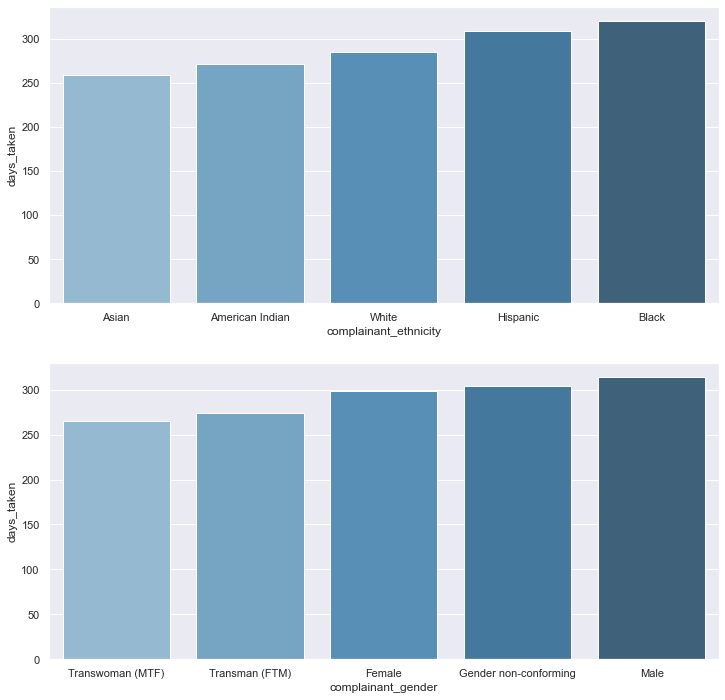

In [124]:
fig, axes = plt.subplots(2, 1, figsize = (12, 12))

complaint_duration_by_ethnicity = pd.concat([complaints['days_taken'].dt.days, complaints['complainant_ethnicity']], axis = 1).groupby("complainant_ethnicity")['days_taken'].mean().sort_values().reset_index() # Calculate average duration for each ethnicity
sns.barplot(data = complaint_duration_by_ethnicity, x = 'complainant_ethnicity', y = 'days_taken', ax=axes[0])

complaint_duration_by_gender = pd.concat([complaints['days_taken'].dt.days, complaints['complainant_gender']], axis = 1).groupby("complainant_gender")['days_taken'].mean().sort_values().reset_index() # Calculate average duration for each gender
sns.barplot(data = complaint_duration_by_gender, x = 'complainant_gender', y = 'days_taken', ax=axes[1])

From the bar graphs, Asian complaints resolve quickest and black complaints resolve slowest. Transwoman complaints resolve quickest while male complaints resolve slowest. Let's conduct a hypothesis test to see the variation between these categories and their average case durations are significant:
- Null hypothesis: Race (and gender) are not related to case duration - the low average case duration for Asian ethnicity and transwoman identity is strictly due to random chance alone
- Alternative hypothesis: Race (and gender) are not related to case duration - the low average case duration for Asian ethnicity and transwoman identity is not due to random chance
- Test statistic: Average case duration in days
- Significance level: 0.05

In [125]:
complaints.groupby("complainant_ethnicity")['days_taken'].agg(['mean', 'count'])

,mean,count
complainant_ethnicity,,
American Indian,271 days 02:15:00,64
Asian,258 days 18:01:21.509433964,530
Black,320 days 01:24:23.643800396,17114
Hispanic,308 days 22:46:00.261600748,6422
White,284 days 19:58:16.477354420,2782


Our question states that 530 Asian complainants were drawn uniformly at random from the main population of 26912 known complainant ethnicities. That is, if we randomly draw 530 complainants from the main population and compute the average case duration, it would not be unreasonable to see an average case duration as low as our observed. To abstractify this procedure, we will create a function that can conduct this hypothesis test for any ethnicity and gender:
- Compute the count of the given ethnicity or gender
- Filter out all missing values of the given category, sample the case duration, and compute mean case duration (test statistic)
- Get observed case duration
- Plot results

In [126]:
def conduct_case_duration_hypothesis_test(column_name, category, infunc):
    # Compute the count of the given ethnicity or gender
    num_to_sample = complaints.groupby(column_name)['days_taken'].agg(['mean', 'count']).loc[category, 'count']

    # Filter out all missing values of the given category, sample the case duration, and compute mean case duration (test statistic)
    ts = np.random.choice(complaints[~complaints[column_name].isna()]['days_taken'].dt.days, size = (10000, num_to_sample)).mean(axis = 1)

    # Get observed case duration
    obs = complaints.groupby(column_name)['days_taken'].agg(['mean', 'count']).loc[category, 'mean'].days

    if infunc:
        ax = sns.histplot(data = ts, kde = True)

        # Plot observed, test statistics, and the 5th and 95 percentiles
        plt.axvline(np.percentile(ts, 5), color = 'black')
        plt.axvline(np.percentile(ts, 95), color = 'black')
        plt.axvline(obs, color = 'red')
        ax.set_title(f"Average case duration simulated under {category} group")
    return ts, obs

Now, let's see what our function has returned.

(array([309.50566038, 317.38301887, 310.33773585, ..., 300.06792453,
        309.24716981, 314.9245283 ]),
 258)

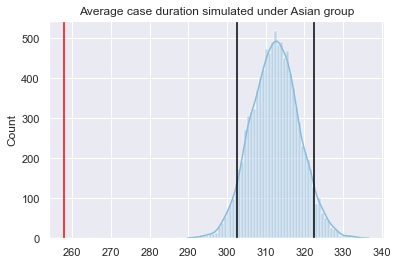

In [127]:
conduct_case_duration_hypothesis_test('complainant_ethnicity', 'Asian', True)

The red line represents the observed value. In this case, it is the average case duration for the Asian ethnicity in our `complaints` dataframe. The black lines represent the 5th and 95th percentiles, respectively. Since our red line is far left of the 5th percentile, we reject our null hypothesis. However, this does not establish causality between ethnicity and case duration. Out of curiosity, let's call the function on the remaining ethnicities and see if their average case durations are reasonable under the null hypothesis.

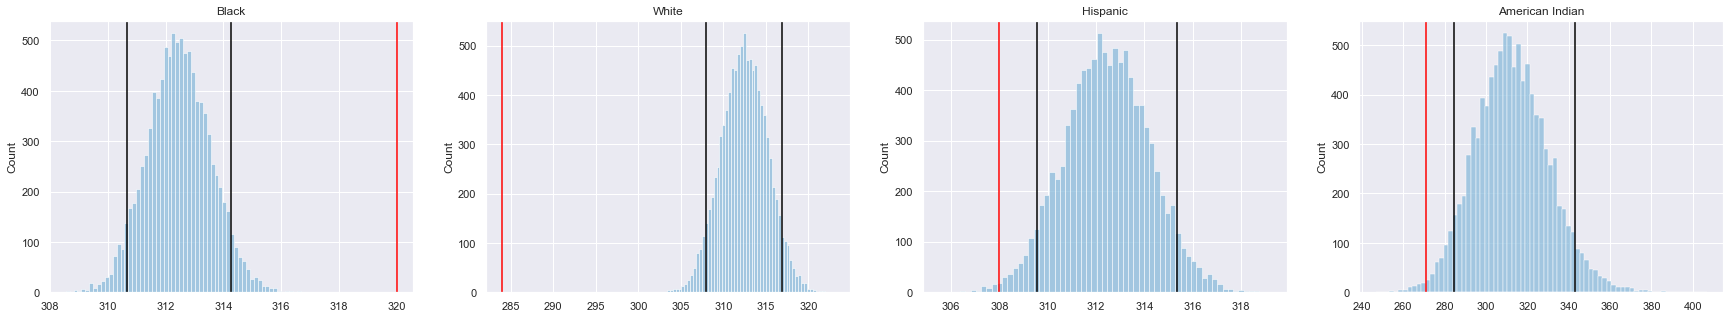

In [128]:
ethnicities = ['Black', "White", "Hispanic", "American Indian"] # Conducts hypothesis tests for these ethnicities and plots

fig, axes = plt.subplots(1, 4, figsize = (30, 5))
for i, ethnicity in enumerate(ethnicities):
    ts, obs = conduct_case_duration_hypothesis_test('complainant_ethnicity', ethnicity, False)
    ax = sns.histplot(data = ts, ax = axes[i])
    ax.axvline(np.percentile(ts, 5), color = 'black')
    ax.axvline(np.percentile(ts, 95), color = 'black')
    ax.set_title(ethnicity)
    ax.axvline(obs, color = 'red')

It seems that, for all ethnicities, we reject their respective null hypotheses.

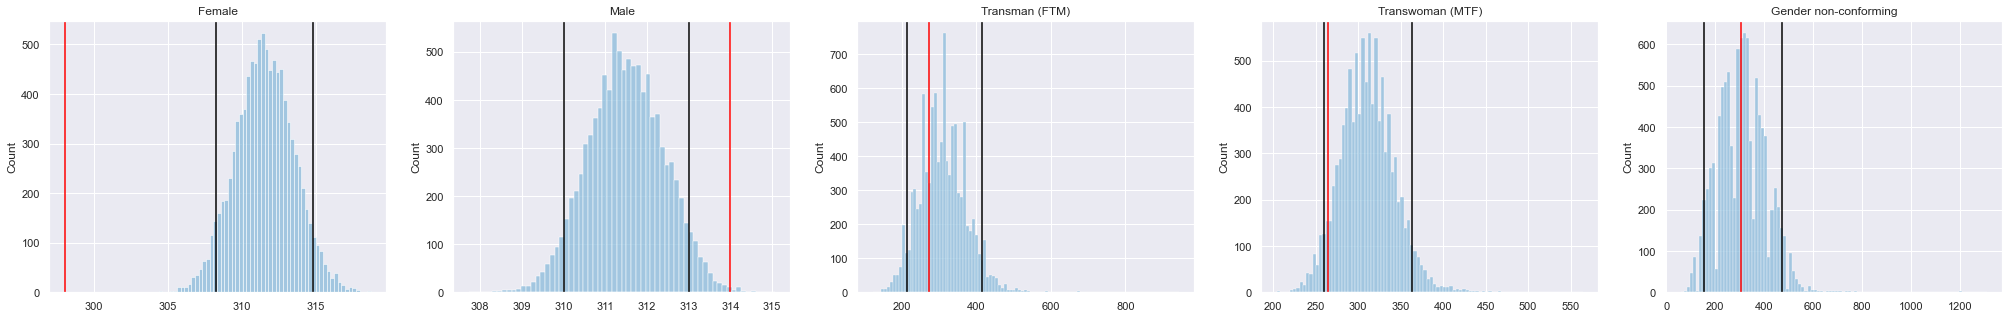

In [129]:
genders = list(filter(lambda gender: not pd.isnull(gender), complaints['complainant_gender'].unique())) # Conducts hypothesis tests for these genders and plots

fig, axes = plt.subplots(1, 5, figsize = (35, 5))
for i, gender in enumerate(genders):
    ts, obs = conduct_case_duration_hypothesis_test('complainant_gender', gender, False)
    ax = sns.histplot(data = ts, ax = axes[i])
    ax.axvline(np.percentile(ts, 5), color = 'black')
    ax.axvline(np.percentile(ts, 95), color = 'black')
    ax.set_title(gender)
    ax.axvline(obs, color = 'red')

We reject the null hypothesis for females and males. However, for non-binary individuals, we can reasonably expect to see their average case duration in the broader population. What about age, a quantitative variable, and its effect on case duration?

In [130]:
corr = pd.concat([complaints['days_taken'].dt.days, complaints['complainant_age_incident']], axis = 1).corr().loc['days_taken', 'complainant_age_incident']
print(f"Correlation coefficient: {corr}")

Correlation coefficient: -0.08829312664488052


The correlation is very low between the two variables, and so it is difficult to determine their relationship. Let's take another approach by grouping ages by intervals of 5, and then plotting the average case duration for each age group.

In [131]:
# Groups ages into 5 year intervals
def assign_age_groups(complaints):
    age_df = pd.DataFrame()
    def round_to_five(age):
        tenths, ones = age//10, age % 10
        if ones >= 0 and ones < 5:
            ones = 0
        else:
            ones = 5
        return str((tenths * 10) + ones) + "-" + str((tenths * 10) + ones + 4)
    age_df['complainant_age_group'] = complaints['complainant_age_incident'].apply(round_to_five)
    concatenated = pd.concat([age_df, complaints['days_taken'].dt.days], axis = 1).replace({"nan-nan": np.nan})
    return concatenated[~concatenated['complainant_age_group'].isna()] # Filter out all nan age groups
age_groups = assign_age_groups(complaints)
age_groups.head()

,complainant_age_group,days_taken
0,35.0-39.0,305.0
1,25.0-29.0,274.0
2,25.0-29.0,274.0
3,45.0-49.0,427.0
4,15.0-19.0,184.0


In [132]:
# Calculate group means
complaint_duration_by_age_groups = age_groups.groupby("complainant_age_group")['days_taken'].agg(['mean', 'count']).sort_values(by = 'mean').reset_index()
complaint_duration_by_age_groups.head()

,complainant_age_group,mean,count
0,75.0-79.0,217.661290,62
1,80.0-84.0,242.111111,18
2,70.0-74.0,257.350000,100
3,65.0-69.0,257.838384,198
4,60.0-64.0,281.353846,390


<AxesSubplot:xlabel='complainant_age_group', ylabel='mean'>

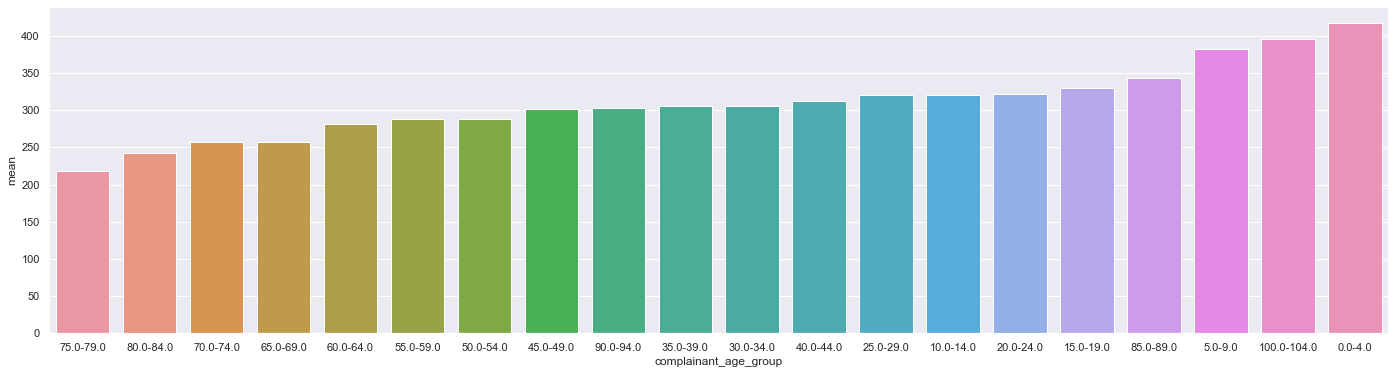

In [133]:
plt.figure(figsize = (24, 6))
sns.barplot(data = complaint_duration_by_age_groups, x = 'complainant_age_group', y = 'mean')

There isn't a clear pattern in the bar plot indicating whether age affects case duration. However, we can conduct a hypothesis test similar to the ones above in which we sample randomly from `complaints`:

- Null hypothesis: Age and case duration are not related - if we sample from the main population, it is reasonable to see our observed value
- Alternative hypothesis: Age and case duration are related - if we sample from the main population, it isn't reasonable to see our observed value
- Test statistic: Absolute difference between population mean and group mean
- Significance level: 0.05

In [134]:
def conduct_case_duration_age_hypothesis_test(age_group):
    population_mean = age_groups['days_taken'].mean()
    obs = abs(complaint_duration_by_age_groups.loc[complaint_duration_by_age_groups['complainant_age_group'] == age_group, 'mean'] - population_mean).iloc[0]
    count = complaint_duration_by_age_groups.loc[complaint_duration_by_age_groups['complainant_age_group'] == age_group, 'count'].iloc[0]
    ts = abs(np.random.choice(age_groups['days_taken'], size = (20000, count)).mean(axis = 1) - population_mean)
    return np.mean(ts > obs)

Let's run this function (conducts hypothesis test for a given age group) for each age group.

In [135]:
reject_null_count = []

for group in age_groups['complainant_age_group'].unique():
    result = conduct_case_duration_age_hypothesis_test(group)
    reject_null_count.append(result < 0.05)
    print(f"P-value for {group}: {result}\nReject null hypothesis: {result < 0.05}\n")
print(f"Proportion of tests rejecting null: {np.mean(reject_null_count)}")

P-value for 35.0-39.0: 0.01455
Reject null hypothesis: True

P-value for 25.0-29.0: 0.0
Reject null hypothesis: True

P-value for 45.0-49.0: 0.0016
Reject null hypothesis: True

P-value for 15.0-19.0: 0.0
Reject null hypothesis: True

P-value for 30.0-34.0: 0.00635
Reject null hypothesis: True

P-value for 60.0-64.0: 0.0
Reject null hypothesis: True

P-value for 40.0-44.0: 0.7909
Reject null hypothesis: False

P-value for 20.0-24.0: 0.0
Reject null hypothesis: True

P-value for 50.0-54.0: 0.0
Reject null hypothesis: True

P-value for 65.0-69.0: 0.0
Reject null hypothesis: True

P-value for 55.0-59.0: 0.0
Reject null hypothesis: True

P-value for 10.0-14.0: 0.1971
Reject null hypothesis: False

P-value for 75.0-79.0: 0.0
Reject null hypothesis: True

P-value for 70.0-74.0: 0.0006
Reject null hypothesis: True

P-value for 80.0-84.0: 0.03515
Reject null hypothesis: True

P-value for 90.0-94.0: 0.92525
Reject null hypothesis: False

P-value for 5.0-9.0: 0.11945
Reject null hypothesis: Fals

We conducted a hypothesis test for each age group. 65 percent of the tests fail to reject the null hypothesis, meaning that more than half of our age groups show significant enough difference from the population sample to suggest relation between age and case duration.

#### Does officer ethnicity affect the outcome of the complaint?

An important aspect of this dataframe is the final result of the complaint. This is captured by the column `board_disposition`. The column has 3 main values corresponding to different decrees according to the `dispositions` dataframe.

In [136]:
for index, row in dispositions.iterrows():
    print(row['Disposition'] + ": " + row['Description'], end = "\n\n")
display(list(complaints['board_disposition'].unique()))

Substantiated: The alleged conduct occurred and it violated the rules. (A breakdown of the types of discipline the CCRB can recommend is here: https://www1.nyc.gov/site/ccrb/prosecution/police-discipline.page) The NYPD can choose to ignore those recommendations. It has discretion over what, if any, discipline is imposed.)

Exonerated: The alleged conduct occurred but did not violate the NYPD’s rules, which often give officers significant discretion over use of force.

Unsubstantiated: The CCRB has fully investigated but could not affirmatively conclude both that the conduct occurred and that it broke the rules.



['Substantiated (Command Lvl Instructions)',
 'Substantiated (Charges)',
 'Substantiated (Command Discipline A)',
 'Substantiated (Formalized Training)',
 'Unsubstantiated',
 'Exonerated',
 'Substantiated (Command Discipline B)',
 'Substantiated (Instructions)',
 'Substantiated (Command Discipline)',
 'Substantiated (No Recommendations)',
 nan,
 'Substantiated (MOS Unidentified)']

Let's binarize the `board_disposition` column by assigning 0 for exonerated cases and 1 for substantiated cases.

In [137]:
# Convert to 0s and 1s
complaints['complainant_won'] = complaints['board_disposition'].apply(lambda disposition: np.nan if pd.isna(disposition) else 1 if "Substantiated" in disposition else 0)
complaints[['board_disposition', 'complainant_won']].head(8)

,board_disposition,complainant_won
0,Substantiated (Command Lvl Instructions),1.0
1,Substantiated (Charges),1.0
2,Substantiated (Charges),1.0
3,Substantiated (Charges),1.0
4,Substantiated (Command Discipline A),1.0
5,Substantiated (Command Lvl Instructions),1.0
6,Substantiated (Formalized Training),1.0
7,Unsubstantiated,0.0


Let's visualize the win percentage for each complainant ethnic group.

<AxesSubplot:xlabel='complainant_ethnicity', ylabel='complainant_won'>

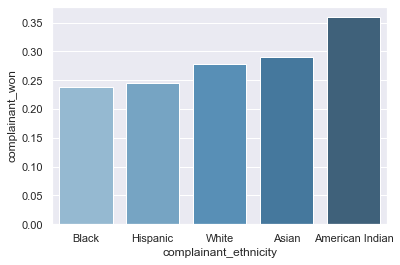

In [138]:
sns.barplot(data = pd.DataFrame(complaints.groupby("complainant_ethnicity")['complainant_won'].mean().sort_values()).reset_index(), x = 'complainant_ethnicity', y = 'complainant_won')

Every complainant ethnicity has different win percentages. What about officer ethnicity win percentage?

<AxesSubplot:xlabel='mos_ethnicity', ylabel='complainant_won'>

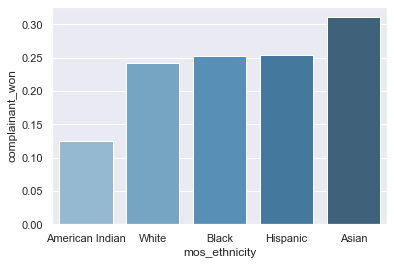

In [139]:
sns.barplot(data = pd.DataFrame(complaints.groupby("mos_ethnicity")['complainant_won'].mean().sort_values()).reset_index(), x = 'mos_ethnicity', y = 'complainant_won')

What about the win percentages of specific officer-complainant ethnicity combinations?

In [207]:
complaints.pivot_table(index = 'mos_ethnicity', columns='complainant_ethnicity', aggfunc = 'mean', values= 'complainant_won', fill_value=0)

complainant_ethnicity,American Indian,Asian,Black,Hispanic,White
mos_ethnicity,,,,,
American Indian,0.000,0.000000,0.222222,0.000000,0.000000
Asian,0.500,0.459016,0.292115,0.254237,0.403101
Black,0.250,0.189655,0.234715,0.239774,0.323684
Hispanic,0.125,0.265957,0.240576,0.248758,0.267200
White,0.400,0.283912,0.234337,0.242638,0.263670


Specifically, what are the win percentages of complainants by ethnicity against white officers?

In [141]:
compare_win_percentages = pd.concat([complaints.groupby("complainant_ethnicity")['complainant_won'].mean(), complaints.pivot_table(index = 'mos_ethnicity', columns='complainant_ethnicity', aggfunc = 'mean', values= 'complainant_won').loc['White']], axis = 1).rename(columns = {"complainant_won": "Win % against officers in general", "White": "Win % against white officer"})
compare_win_percentages.index.name = 'Complainant ethnicity'
compare_win_percentages

,Win % against officers in general,Win % against white officer
Complainant ethnicity,,
American Indian,0.359375,0.400000
Asian,0.290566,0.283912
Black,0.237992,0.234337
Hispanic,0.244784,0.242638
White,0.278936,0.263670


This pivot table gives us a matrix of probabilities corresponding to the chance that a complainant with a certain ethnicity would win their case against a police officer of a certain ethnicity. Let's see if complaining against a white officer affects the final outcome of the complaint.

Text(0.5, 1.0, 'Win percentages')

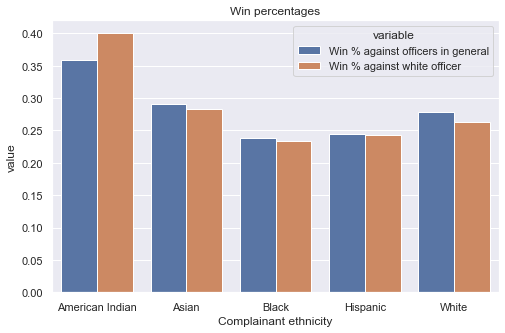

In [142]:
plt.figure(figsize = (8, 5))
ax = sns.barplot(data = compare_win_percentages.melt(ignore_index = False).reset_index(), x = 'Complainant ethnicity', y = 'value', hue = 'variable', palette="deep")
ax.set_title("Win percentages")

In the above plot, we can see a slight difference between the win percentages of complaints against white officers and against a general population of officers. To know if the win percentages against white officers are significantly different than those against officers in general, we will conduct a hypothesis test (not a permutation test because our true probability model EXISTS as the win percentages against officers in general):
- Null hypothesis: Complainant ethnicity groups win the same amount against officers in general as they do against white officers - win percentage disparity is strictly due to chance
- Alternative hypothesis: Complainant ethnicity groups do not win the same amount against officers in general as they do against white officers - win percentage disparity is not due to chance
- Test statistic: Total variation distance
- Significance level: 0.05

In [201]:
def conduct_ethnicity_disposition_permutation_test(N):
    counts = complaints.pivot_table(index = 'mos_ethnicity', columns = 'complainant_ethnicity', aggfunc= 'count', values='complainant_won')
    population_percentages = np.array(complaints.groupby("complainant_ethnicity")['complainant_won'].mean()).reshape(5, 1) # To use to calculate TVD
    white_percentages = np.array(compare_win_percentages['Win % against white officer']).reshape(5, 1) # To use to calculate observed TVD
    obs_tvd = distance_measures.total_variation_distance(white_percentages, population_percentages)
    races = counts.index
    percentages = np.array([])
    tvds = []
    for _ in range(N):
        # For each race, calculate win percentage
        for race in races:
            count = int(counts.loc['White', race])
            simulated_percentage = np.random.choice(complaints[complaints['mos_ethnicity'] == 'White']['complainant_won'], size = (1, count)).mean(axis = 1)[0]
            percentages = np.append(percentages, simulated_percentage)
        percentages = percentages.reshape(5, 1)
        tvds.append(distance_measures.total_variation_distance(population_percentages, percentages))
        percentages = np.array([])
    tvds = np.array(tvds)
    return tvds, obs_tvd
tvds, obs_tvd = conduct_ethnicity_disposition_permutation_test(1000)

Now that we have our total variation distances and observed value, let's plot.

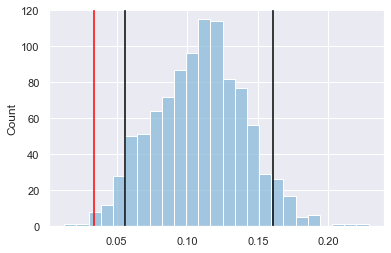

In [205]:
sns.histplot(data = tvds)
plt.axvline(np.percentile(tvds, 5), color = 'black')
plt.axvline(np.percentile(tvds, 95), color = 'black')
plt.axvline(obs_tvd, color = 'red')

Because our observed value is below our 0.05 significance threshold, we reject the null hypothesis in favor of the alternative. This means that there might be some form of relationship in win percentage against officers of different races. To quantify, we can calculate our p-value.

In [206]:
print(f"P-value: {np.mean(tvds <= obs_tvd)}")

P-value: 0.006


### Does gender play a role in winning a case?

What are the gender proportions for officers? For complainants?

In [151]:
display(complaints['mos_gender'].value_counts(normalize = True))
display(complaints['complainant_gender'].value_counts(normalize = True))

M    0.947201
F    0.052799
Name: mos_gender, dtype: float64

Male                     0.826535
Female                   0.172537
Transwoman (MTF)         0.000687
Transman (FTM)           0.000172
Gender non-conforming    0.000069
Name: complainant_gender, dtype: float64

What are the top reasons why an officer made contact for each complainant gender group? Why did the complainant have a complaint in the first place?

In [152]:
most_common_reasons_by_gender = complaints.groupby("complainant_gender").agg(lambda series: series.value_counts().index[0])[['fado_type', 'allegation', 'contact_reason']]
most_common_reasons_by_gender.style.set_caption("Most common reasons by gender")

,fado_type,allegation,contact_reason
complainant_gender,,,
Female,Abuse of Authority,Word,PD suspected C/V of violation/crime - street
Gender non-conforming,Abuse of Authority,Interference with recording,C/V at PCT to file complaint of crime
Male,Abuse of Authority,Physical force,PD suspected C/V of violation/crime - street
Transman (FTM),Discourtesy,Word,Report-dispute
Transwoman (MTF),Abuse of Authority,Gender,PD suspected C/V of violation/crime - street


What are the general win percentages for each gender? What about the general duration it took for these cases?

In [217]:
pd.concat([complaints.groupby("complainant_gender")[['complainant_won']].mean(), complaints.groupby("complainant_gender")[['days_taken']].mean()], axis= 1)

,complainant_won,days_taken
complainant_gender,,
Female,0.205537,298 days 20:01:57.586138220
Gender non-conforming,1.000000,304 days 00:00:00
Male,0.255644,314 days 05:07:14.490500144
Transman (FTM),0.400000,274 days 00:00:00
Transwoman (MTF),0.550000,264 days 19:12:00


Do females have a higher complaint success rate than men for the same allegations? Let's use `fado_type`, which is a generalization of the allegation column and thus has less unique values.

<AxesSubplot:xlabel='fado_type', ylabel='value'>

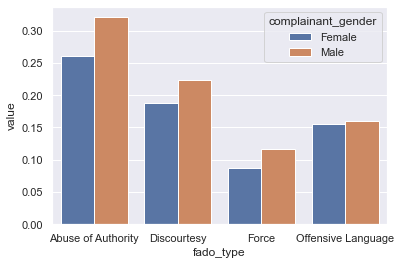

In [230]:
gender_and_allegation_pt = complaints.pivot_table(index = 'fado_type', columns = 'complainant_gender', values='complainant_won', aggfunc="mean", fill_value=0)
sns.barplot(data = gender_and_allegation_pt[['Female', 'Male']].melt(ignore_index= False).reset_index(), x = 'fado_type', y = 'value', hue = 'complainant_gender', palette='deep')

Interesting! It seems that, across all types of complaints, women lose a disproportionate amount of their cases than men do. Because we are comparing the categorical distribution of win percentage for females against the categorical distribution of win percentage for males without knowledge of the *correct* probability model, let's formulate a permutation test:
- Null hypothesis: The distribution of percent chance of winning a complaint for men is the same as that for females
- Alternative hypothesis: The distribution of percent chance of winning a complaint as a female is less than that for men
- Test statistic: Sum of proportion differences between female and men ($\sum_{i=1}female _i  - male _i $)
- Significance level: 0.05

In [286]:
def conduct_gender_fado_permutation_test(N):
    ts = np.array([])
    obs = gender_and_allegation_pt[['Female', 'Male']].diff(periods = -1, axis = 1)['Female'].sum() # Calculate observed value
    for _ in range(N):
        filtered_genders = complaints[['complainant_won', 'complainant_gender', 'fado_type']][(complaints['complainant_gender'] == 'Female') | (complaints['complainant_gender'] == 'Male')] # Get only male and female genders
        filtered_genders['shuffled_gender'] = np.random.permutation(filtered_genders['complainant_gender']) # Permute genders
        ts = np.append(ts, filtered_genders.pivot_table(index = 'fado_type', columns = 'shuffled_gender', values='complainant_won', aggfunc="mean", fill_value=0).diff(periods = -1, axis = 1)['Female'].sum()) # Calculate test statistic using permuted gender column
    return ts, obs, np.mean(ts <= obs)
ts, obs, p = conduct_gender_fado_permutation_test(1000)

Let's plot our results.

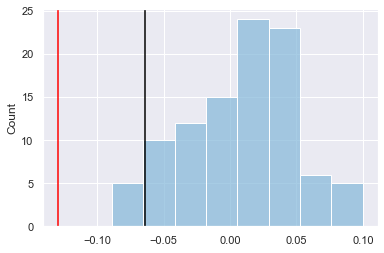

In [284]:
sns.histplot(data = ts)
plt.axvline(np.percentile(ts, 5), color = 'black')
plt.axvline(obs, color = 'red')

It seems that our observed value is extreme and below our 0.05 significance threshold. Thus, we will reject the null hypothesis, suggesting - but not establishing causality - that females lose cases more frequently than men do.

In [288]:
print(f"P-value: {p}")

P-value: 0.0


### Assessment of data missingness:

In this section, we will categorize our dataset's missingness into MD, NMAR, MAR, and MCAR categories.

<AxesSubplot:>

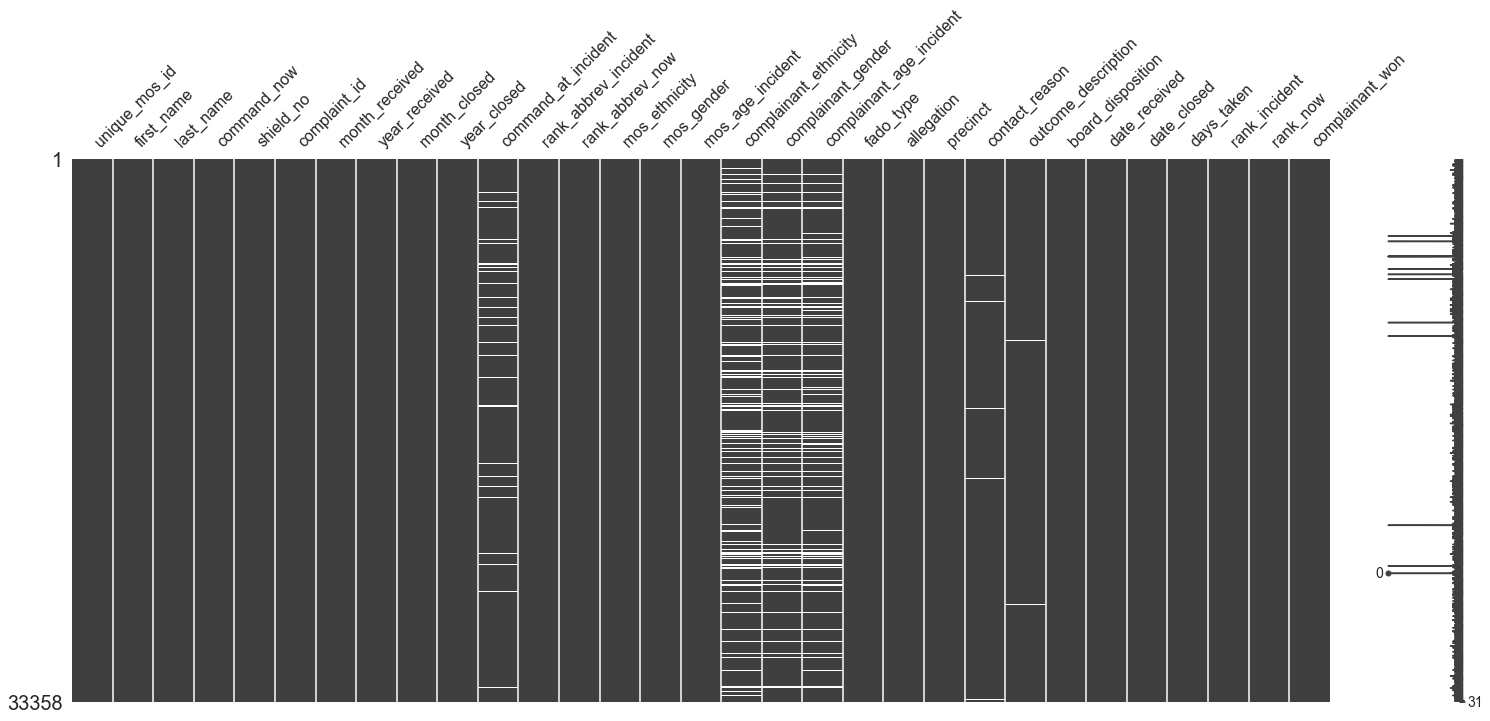

In [513]:
msno.matrix(complaints)

Let's assess missingness for `complainant_gender`, `complainant_ethnicity`, and `complainant_age_incident` because these features have a large proportion of missing data. We will reason about missingness by questioning the data at each category to identify the best category.

- Missing by design: For all columns, there is nothing in the dataset that allows us to determine whether the value is missing using other columns
- Not missing at random: 
    - `complainant_gender` reasons include: 
        - The complainant does not identify with existing gender choices
        - The complainant does not want to disclose their gender for privacy reasons
        - Fix: Collect information about privacy (not very strong)
    - `complainant_ethnicity` reasons include: 
        - The complainant does not identify with existing ethnicity choices
        - The complainant does not want to disclose their ethnicity for privacy reasons
        - Fix: Collect information about privacy (not very strong)
    - `complainant_age` reasons include: 
        - The complainant is too young and they feel uncomfortable sharing
        - Fix: Collect information about whether or not the complainant's parent filed it for them
- Missing at random: For `complainant_gender`, `complainant_ethnicity`, and `complainant_age_incident`, we can run a permutation test to determine if these columns are dependent on other columns in the dataset
- Missing completely at random: If our permutation tests do not establish MAR, there is still not enough evidence in the data and its underlying generative process to suggest that missing values are completely missing at random

Let's run our MAR permutation tests by creating a general purpose function.

In [540]:
# Is gender missingness dependent on age



0.0

<AxesSubplot:title={'center':"Father's Height by Missingness of Child Height"}, ylabel='Frequency'>

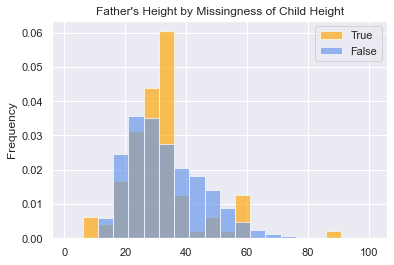

In [503]:
pd.concat([true_ob, false_ob], axis = 1).plot(kind='hist', density=True, alpha=0.65, ec='w', bins=20, legend=True, title="Father's Height by Missingness of Child Height", color = ['orange', 'cornflowerblue'])

In [544]:
def conduct_MAR_permutation_test(col_1_name, col_2_name, is_col_2_categorical, N = 300):
    if is_col_2_categorical:
        ts = []

        # Calculate observed test statistic
        pt_ob = complaints.assign(missing = complaints[col_1_name].isna()).pivot_table(index = col_2_name, columns='missing', aggfunc='size', fill_value=0)
        pt_ob = pt_ob/pt_ob.sum()
        false_ob = np.array(pt_ob[False]).reshape(5, 1)
        true_ob = np.array(pt_ob[True]).reshape(5, 1)
        obs = distance_measures.total_variation_distance(false_ob, true_ob)

        # Simulate
        for _ in range(N):
            shuffled = complaints.copy().assign(missing = complaints[col_1_name].isna()) # Copy dataframe
            shuffled['shuffled'] = np.random.permutation(shuffled[col_2_name]) # Shuffle col2
            pt = shuffled.pivot_table(index = 'shuffled', columns = 'missing', aggfunc = 'size', fill_value = 0).apply(lambda x: x / x.sum()) # Get proportions
            # Calculate test statistic
            false = np.array(pt[False]).reshape(5, 1)
            true = np.array(pt[True]).reshape(5, 1)
            ts.append(distance_measures.total_variation_distance(false, true))
            
        # Plot
        plt.figure(figsize = (16, 4))
        sns.histplot(data = ts)
        plt.axvline(np.percentile(ts, 95), color = 'black')
        plt.axvline(obs, color = 'red')
        p = np.mean(np.array(ts) >= obs)

        # Evaluate p-value
        if p <= 0.05:
            return f"{col_1_name}'s missingness is tied to {col_2_name}"
        else:
            return f"{col_1_name}'s missingness is tied to {col_2_name}"
    else:
        ts = []

        # Use kolmogorov-smirnov statistic to quantify differences between two numerical distributions
        groups_ob = complaints.assign(missing = complaints[col_1_name].isna()).groupby("missing")[col_2_name]
        true_ob = groups_ob.get_group(True).rename("True")
        false_ob = groups_ob.get_group(False).rename("False")
        p = ks_2samp(true_ob, false_ob).pvalue

        if p <= 0.05:
            return f"{col_1_name}'s missingness is tied to {col_2_name}"
        else:
            return f"{col_1_name}'s missingness is tied to {col_2_name}"  

Let's conduct MAR permutation test for `complainant_gender` depending on `complainant_ethnicity`.

"complainant_gender's missingness is tied to complainant_ethnicity"

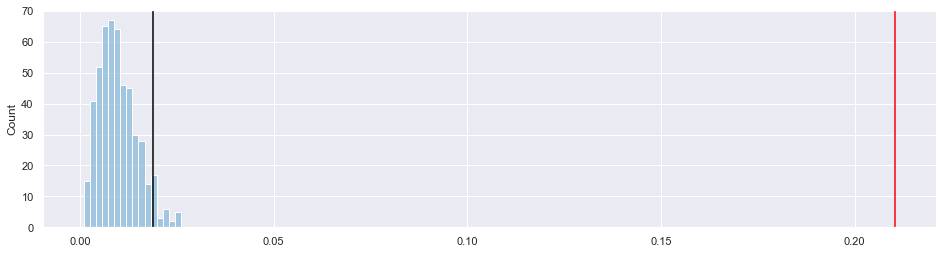

In [545]:
conduct_MAR_permutation_test('complainant_gender', 'complainant_ethnicity', True, N = 500)

$P(col1_{MAR}|col2) = P(col2_{MAR}|col1)$ so we only have to worry about testing combinations and not permutations of columns.

Let's conduct MAR permutation test for `complainant_gender` depending on `complainant_age_incident`.

In [547]:
conduct_MAR_permutation_test('complainant_gender', 'complainant_age_incident', False)

"complainant_gender's missingness is tied to complainant_age_incident"

Let's conduct MAR permutation test for `complainant_ethnicity` depending on `complainant_age_incident`.

In [551]:
conduct_MAR_permutation_test('complainant_ethnicity', 'complainant_age_incident', False)

"complainant_ethnicity's missingness is tied to complainant_age_incident"

Our gatherings:
- `complainant_ethnicity`, `complainant_gender`, and `complainant_age_incident` all depend on eachother and are thus MAR

We can confirm our results through a heatmap.

<AxesSubplot:>

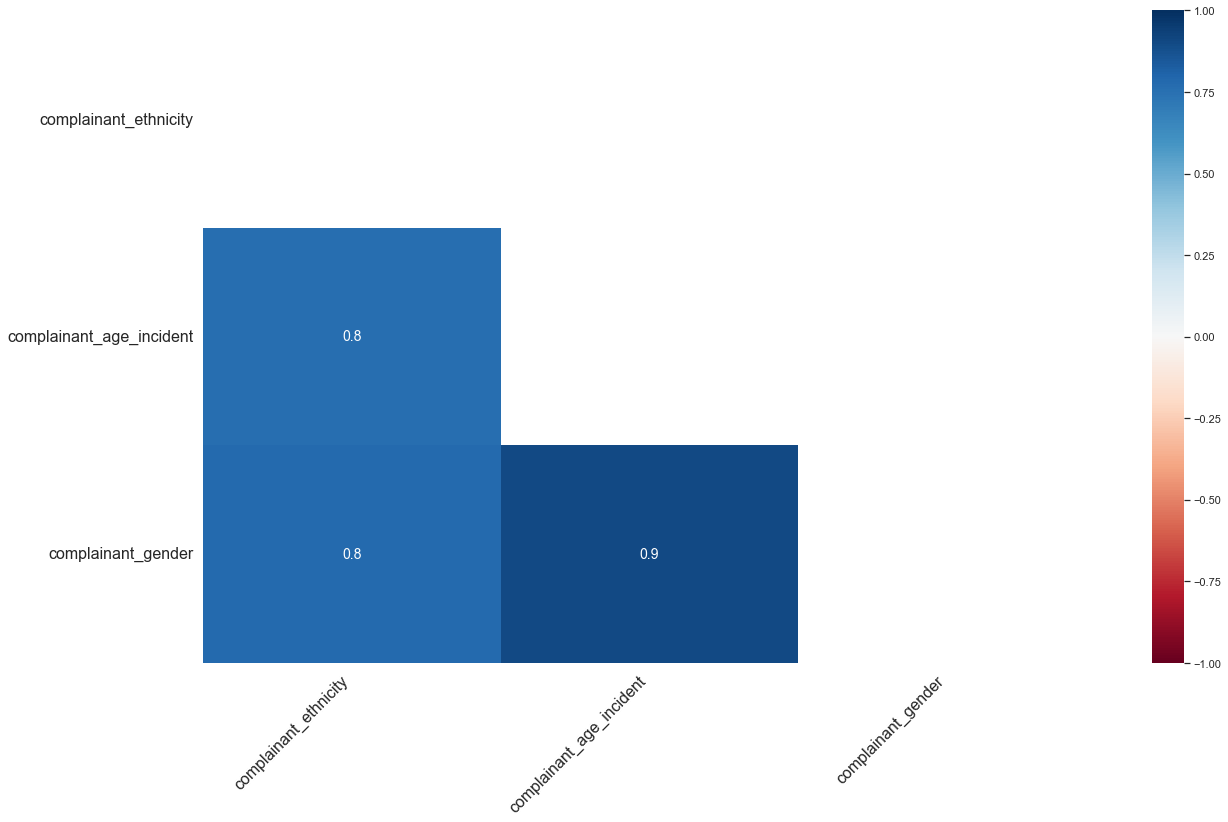

In [552]:
msno.heatmap(complaints[['complainant_ethnicity', 'complainant_age_incident', 'complainant_gender']])

A value close to 1.0 represents that if a value is missing in `col1`, then the value is also missing in `col2`.

### Lingering thoughts and questions:
- Should inferential testing utilize missing values? For instance, when I was conducting my hypothesis test to determine a correlation between ethnicities and case duration, I sampled from a population that did not contain missing ethnicities. Would there be any difference in my testing if I did?
- I have a hard time differentiating between conducting a hypothesis test and permutation test. In addition, sometimes I don't know what to sample from.
- Can't everything by NMAR?